# Heart Rate Variability

## Reading the Data

In [1]:
import os
import time
import math
import subprocess
import numpy as np
import pandas as pd
import hrvanalysis as hrv
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 160
color = sns.color_palette("viridis", 10)[5]
# palette sns.palplot(sns.color_palette("viridis", 10))

In [2]:
# Hyper Parameters
N = 400
SIZE = 5_000
LR = 0.0001
EPOCHS = 30
splits = [0.8, 0.1, 0.1]
SEED = 21
TAKE = 0.5
sigma_outlier = 5
data_dir_out = "../data/age_decades/"
data_dir = "/home/flennic/Downloads/physionet.org/files/crisdb/1.0.0/"
subdirs = ["e/", "f/", "m/"]

In [3]:
def extract_header_information(path):
    with open(path, "r") as file:
        content = file.read()
        #print(content)
        
        start, end = 0, 0
        
        while content.find(">", end) != -1:

            start = content.find(">", end)
            end = content.find("<", start)
            value = content[start+2:end-2].strip()
            
            if value[-1] == ",":
                value = value[0:-1]
            
            if value.find("#") != -1:
                value = value.split("#")[0]
            
            yield(value)

In [4]:
path = data_dir + "e/" + "e238a.hea"
for value in extract_header_information(path):
    print(value)

45-49
Male
None
0.515
1.351



In [5]:
%%time

all_recordings = []

for medicationdir in subdirs:
    
    print(f"Parsing {medicationdir} directory...")
    
    basedir = data_dir + medicationdir
    recordings = list(set([filename.split(".")[0] for filename in os.listdir(basedir) if len(filename.split(".")) == 2 and filename.find("index") == -1]))
    
    for i, recording in enumerate(recordings):
        
        # Status
        print(str(round(i/len(recordings)*100, 2)) + "%", end="\r")
        
        entry = {}
        
        #print("Step -1")
        #print(recording)
        # Filename
        entry["name"] = recording[1:4]
        entry["medication"] = recording[0]
        entry["treatment"] = recording[4] == "b"
        
        #print("Step 0")
        
        # Header
        header_information = [value for value in extract_header_information(basedir + recording + ".hea")]
        entry["age"] = header_information[0]
        entry["gender"] = header_information[1]
        
        #print("Step 1")
        
        try:
            entry["rrlow"] = int(float(header_information[3]) * 1000)
        except ValueError:
            entry["rrlow"] = None
        
        try:
            entry["rrhigh"] = int(float(header_information[4]) * 1000)
        except ValueError:
            entry["rrhigh"] = None
            
        #print("Step 2")
        
        # Recording
        rrintervals = subprocess.check_output(["ann2rr", "-r", recording, "-a", "atr", "-i", "s"], cwd=basedir).splitlines()
        rrintervals = np.array([int(float(value)*1000) for value in rrintervals], dtype=object)
        rrintervals = rrintervals[1:]
        
        #print("Step 3")

        # New outlier analysis

        rrintervals = hrv.remove_outliers(rrintervals, verbose=False)
        
        #print("Step 4")

        # Outlier analysis
        #try:
        #    rrintervals[(rrintervals > entry["rrhigh"]) | (rrintervals < entry["rrlow"])] = np.nan
        #except TypeError:
        #    rrintervals[abs(rrintervals - np.mean(rrintervals)) < sigma_outlier * np.std(rrintervals)] = np.nan

        #print("Parsing")
        entry["Series"] = pd.DataFrame({"ContractionNoNorm": list(range(len(rrintervals))), "RrInterval": rrintervals})

        #print("Step 5")
        
        all_recordings.append(entry)

Parsing e/ directory...
Parsing f/ directory...
Parsing m/ directory...
CPU times: user 2min 49s, sys: 45.9 s, total: 3min 35s
Wall time: 8min 27s


In [6]:
recordings = all_recordings

## Data Analysis

### Amount of Recordings

In [7]:
len(recordings)

1543

### Example Recording

In [8]:
idx = 8

In [9]:
recordings[idx]

{'name': '281',
 'medication': 'e',
 'treatment': True,
 'age': '65-69',
 'gender': 'Male',
 'rrlow': 539,
 'rrhigh': 1031,
 'Series':         ContractionNoNorm  RrInterval
 0                       0       711.0
 1                       1       711.0
 2                       2       711.0
 3                       3       719.0
 4                       4       711.0
 ...                   ...         ...
 106917             106917       688.0
 106918             106918       688.0
 106919             106919       672.0
 106920             106920       688.0
 106921             106921       688.0
 
 [106922 rows x 2 columns]}

### Plotted as Time Series

In [10]:
np.min(recordings[idx]["Series"]["RrInterval"])

492.0

In [11]:
np.max(recordings[idx]["Series"]["RrInterval"])

1992.0

In [12]:
np.sum(recordings[idx]["Series"]["RrInterval"] > 2000) / len(recordings[idx]["Series"]["RrInterval"])

0.0

In [13]:
individuals = {}

for recording in recordings:
    #age = int(recording["age"][0:2])
    #print(recording["age"])
    age = int(int(recording["age"][0:2])/10)*10
    gender = recording["gender"]
    
    if individuals.get(age) == None:
        individuals[age] = {"Male": 0, "Female": 0, "Total": 0}
    
    individuals[age][gender] +=1
    individuals[age]["Total"] +=1

df = pd.DataFrame(individuals).transpose()
df

,Male,Female,Total
50,361,64,425
60,476,128,604
70,236,58,294
40,163,23,186
30,28,4,32
20,2,0,2


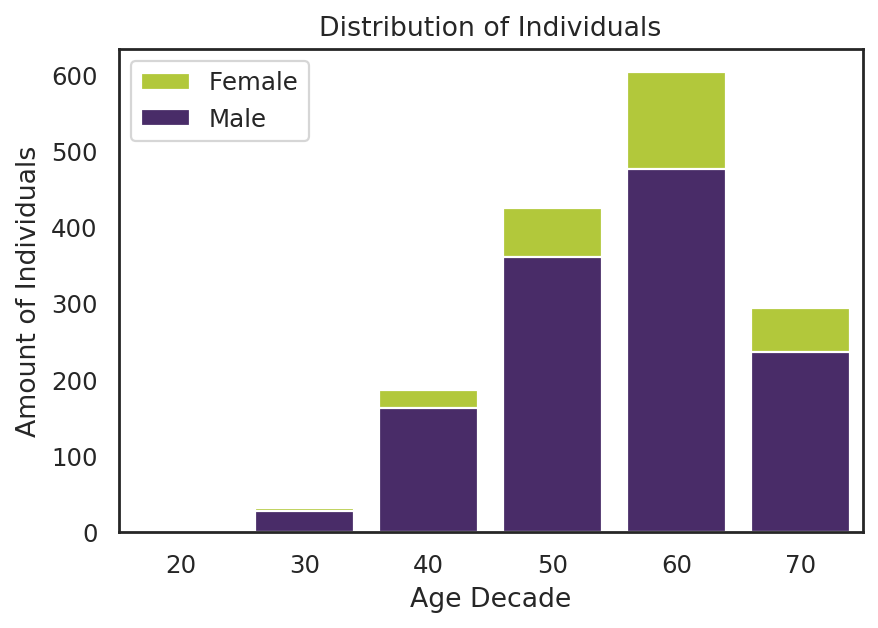

In [14]:
sns.set(style="white")
sns.barplot(data=df, x=df.index, y="Total", color=sns.color_palette("viridis", 10)[9], label="Female");
sns.barplot(data=df, x=df.index, y="Male", color=sns.color_palette("viridis", 10)[0], label="Male");
plt.ylabel('Amount of Individuals');
plt.xlabel('Age Decade');
plt.title('Distribution of Individuals');
plt.legend();

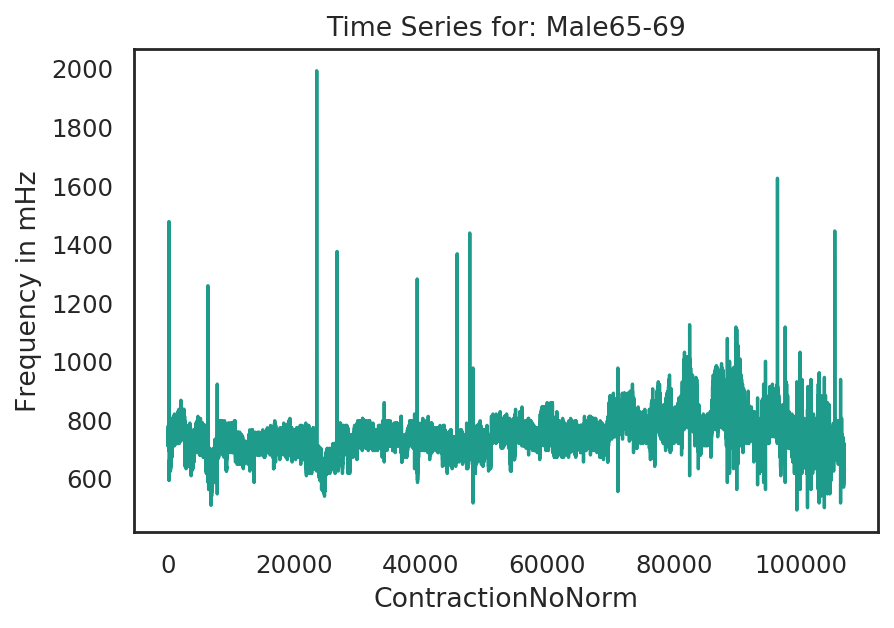

In [15]:
sns.lineplot(recordings[idx]["Series"]["ContractionNoNorm"], recordings[idx]["Series"]["RrInterval"], color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNoNorm');
plt.title('Time Series for: {}{}'.format(recordings[idx]["gender"], recordings[idx]["age"]));

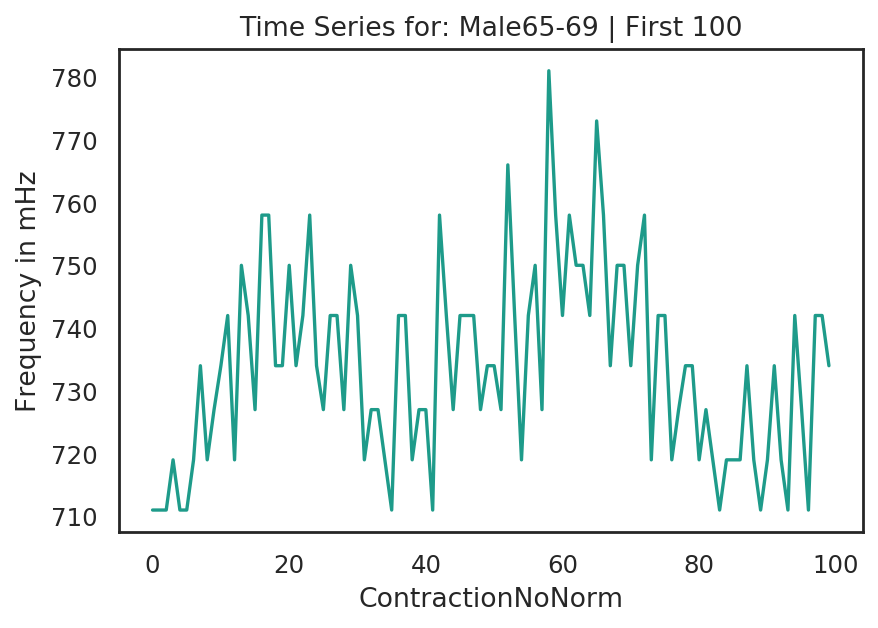

In [16]:
sns.lineplot(recordings[idx]["Series"]["ContractionNoNorm"].head(100), recordings[idx]["Series"]["RrInterval"].head(100), color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNoNorm');
plt.title('Time Series for: {}{} | First 100'.format(recordings[idx]["gender"], recordings[idx]["age"]));

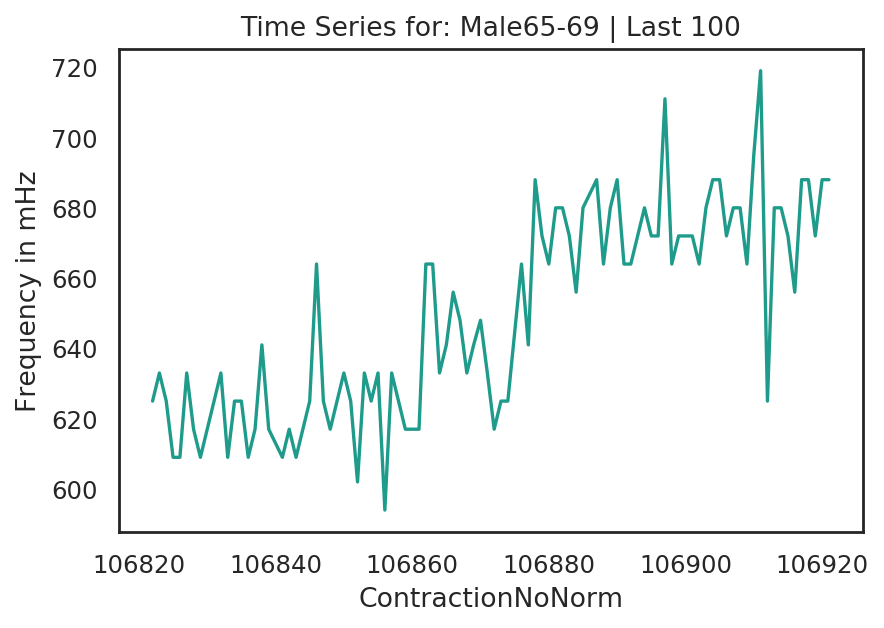

In [17]:
sns.lineplot(recordings[idx]["Series"]["ContractionNoNorm"].tail(100), recordings[idx]["Series"]["RrInterval"].tail(100), color=color);
plt.ylabel('Frequency in mHz');
plt.xlabel('ContractionNoNorm');
plt.title('Time Series for: {}{} | Last 100'.format(recordings[idx]["gender"], recordings[idx]["age"]));

### Distribution of Recording Length

#### Histogram

In [18]:
recording_lengths = [recording["Series"].shape[0] for recording in recordings]

In [19]:
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'b'

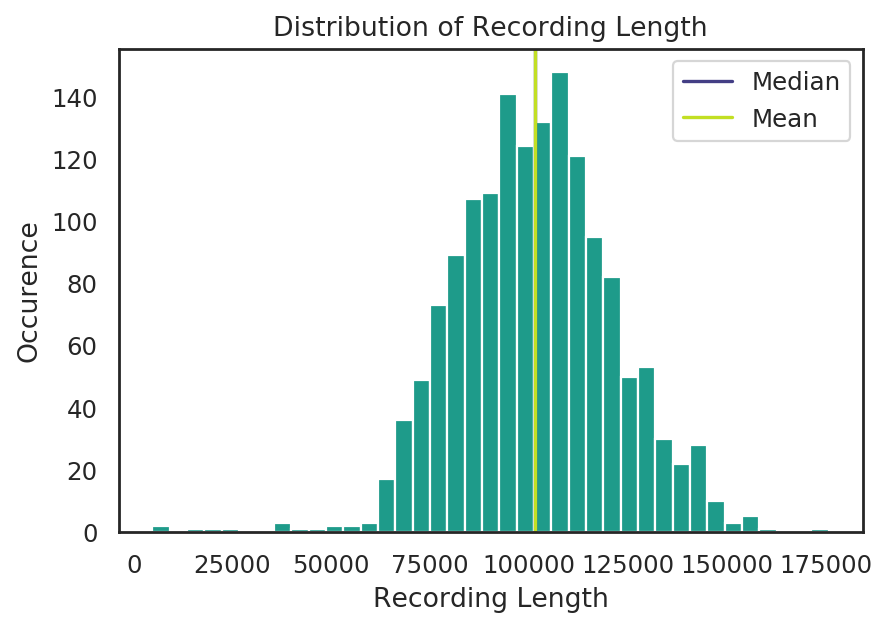

In [20]:
sns.distplot(recording_lengths, kde=False, bins=int(np.sqrt(len(recording_lengths))), color=color, hist_kws={"alpha": 1.0});
plt.axvline(x=np.median(recording_lengths), label="Median", color=sns.color_palette("viridis", 10)[1])
plt.axvline(x=np.mean(recording_lengths), label="Mean", color=sns.color_palette("viridis", 10)[9])
plt.ylabel('Occurence');
plt.xlabel('Recording Length');
plt.legend();
plt.title('Distribution of Recording Length');

#### Median

In [21]:
np.median(recording_lengths)

101612.0

#### Mean

In [22]:
np.mean(recording_lengths)

101537.32922877511

In [23]:
np.quantile(recording_lengths, [0.9, 0.95, 0.99])

array([127485.  , 134837.6 , 146913.06])

### Impurity

#### Global Percentage of Missing Data

In [24]:
%%time
overall_recordings = 0
overall_missing_data = 0

absolute = []
missing_in_recordings_absolute = []
missing_in_recordings_percentage = []

for recording in recordings:
    n = recording["Series"].shape[0]
    missing = len(recording["Series"]["RrInterval"]) - recording["Series"]["RrInterval"].count()

    overall_recordings += n
    overall_missing_data += missing
    
    absolute.append(n)
    missing_in_recordings_absolute.append(missing)
    missing_in_recordings_percentage.append(missing/n*100)

CPU times: user 973 ms, sys: 1.67 s, total: 2.64 s
Wall time: 10.5 s


In [25]:
overall_recordings

156672099

In [26]:
overall_missing_data

467314

In [27]:
overall_missing_data / overall_recordings * 100

0.29827518938135883

In [28]:
overall_missing_data_df = pd.DataFrame({"absolute": absolute, "missing_absolute": missing_in_recordings_absolute, "missing_percentage": missing_in_recordings_percentage})
overall_missing_data_df.head(10)

,absolute,missing_absolute,missing_percentage
0,102785,53,0.051564
1,80830,455,0.562910
2,88299,38,0.043036
3,81933,398,0.485763
4,66544,350,0.525968
5,71294,128,0.179538
6,97205,77,0.079214
7,110472,590,0.534072
8,106922,567,0.530293
9,89361,55,0.061548


In [29]:
overall_missing_data_df['missing_absolute']

0        53
1       455
2        38
3       398
4       350
       ... 
1538    382
1539    153
1540     64
1541     72
1542    130
Name: missing_absolute, Length: 1543, dtype: int64

In [30]:
overall_missing_data_df['missing_absolute'].value_counts(normalize=False, sort=False).sort_values(ascending=False)

49     10
56      9
47      9
67      9
27      9
       ..
522     1
523     1
530     1
531     1
353     1
Name: missing_absolute, Length: 645, dtype: int64

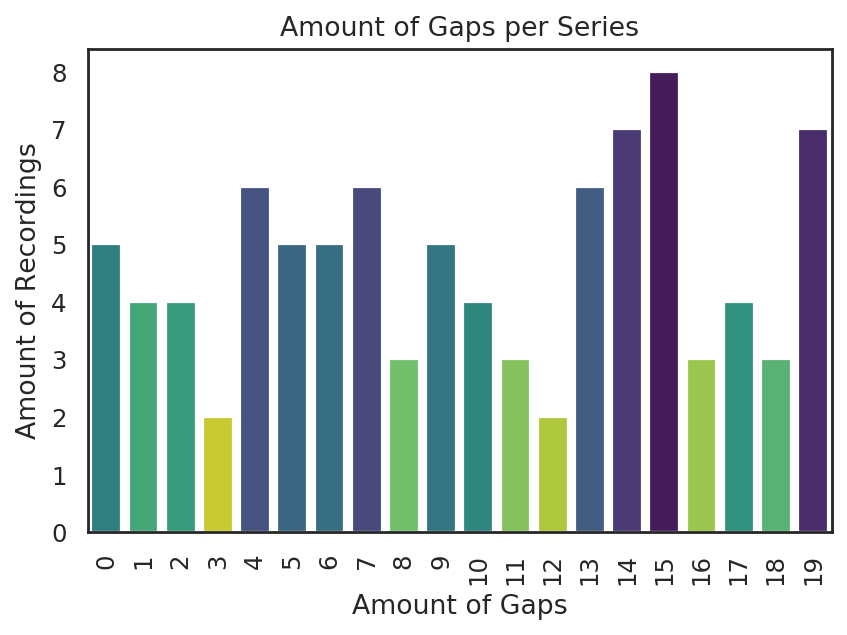

In [31]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

value_counts = overall_missing_data_df['missing_absolute'].value_counts(normalize=False, sort=False)

x = value_counts.index[0:20]
y = value_counts.values[0:20]

pal = sns.color_palette("viridis", len(y))
rank = y.argsort().argsort()
sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])#, hue=x, dodge=False)
plt.xticks(rotation=90)
plt.ylabel('Amount of Recordings');
plt.xlabel('Amount of Gaps');
plt.title('Amount of Gaps per Series');
plt.show()

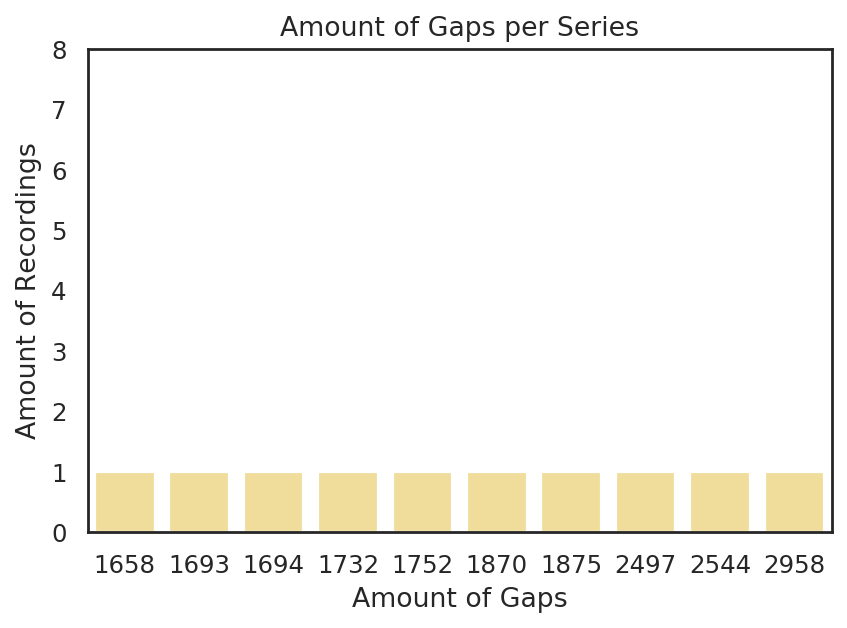

In [32]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

value_counts = overall_missing_data_df['missing_absolute'].value_counts(normalize=False, sort=False)

x = value_counts.index[-10:]
y = value_counts.values[-10:]

pal = sns.color_palette("YlOrRd", len(y))
#rank = y.argsort().argsort()
rank = [1] * 10
#sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])
sns.barplot(x=x, y=y, palette=np.array(pal)[rank])

plt.ylabel('Amount of Recordings');
plt.xlabel('Amount of Gaps');
plt.title('Amount of Gaps per Series');
plt.ylim(0, 8)
plt.show()

#### Length of Missing Data

In [33]:
def extract_recording_gap_length(recording):
    gap_counter = 0
    gap_lengths = []

    for index, row in recording["Series"].iterrows():
        if np.isnan(row["RrInterval"]):
            gap_counter += 1
        if not np.isnan(row["RrInterval"]) and gap_counter != 0:
            gap_lengths.append(gap_counter)
            gap_counter = 0
        
    return gap_lengths

In [34]:
%%time
import multiprocessing as mp
cores = mp.cpu_count()
pool = mp.Pool(cores)
all_gap_lengths_mp = pool.imap(extract_recording_gap_length, recordings)
pool.close()
pool.join()
all_gap_lengths_mp = list(all_gap_lengths_mp)

CPU times: user 3.82 s, sys: 8.22 s, total: 12 s
Wall time: 1h 23s


In [35]:
from itertools import chain
gap_lengths_concatenated = list(chain.from_iterable(all_gap_lengths_mp))
gap_lengths_df = pd.DataFrame({"gap_length": gap_lengths_concatenated})
gap_lengths_df

,gap_length
0,1
1,1
2,1
3,1
4,1
...,...
440854,1
440855,1
440856,1
440857,1


Percentage of gaps being bigger than `limit`.

In [36]:
limit = 45
np.sum([1 if gap > limit else 0 for gap in gap_lengths_concatenated])/len(gap_lengths_concatenated)

0.0

#### Lengths of Missing Data

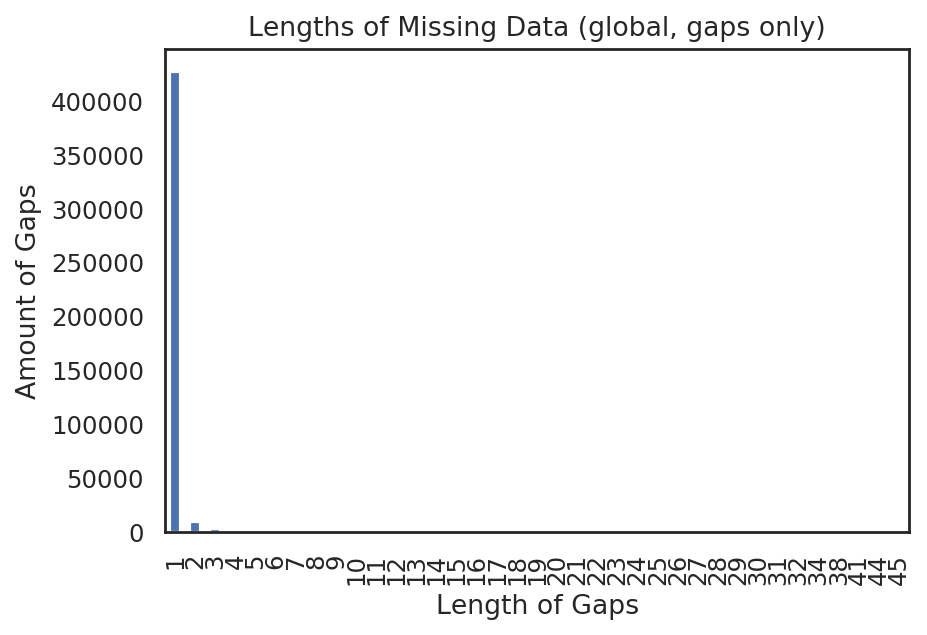

In [37]:
gap_lengths_df['gap_length'].value_counts(normalize=False, sort=False).plot(kind='bar');
plt.ylabel('Amount of Gaps');
plt.xlabel('Length of Gaps');
plt.title('Lengths of Missing Data (global, gaps only)');

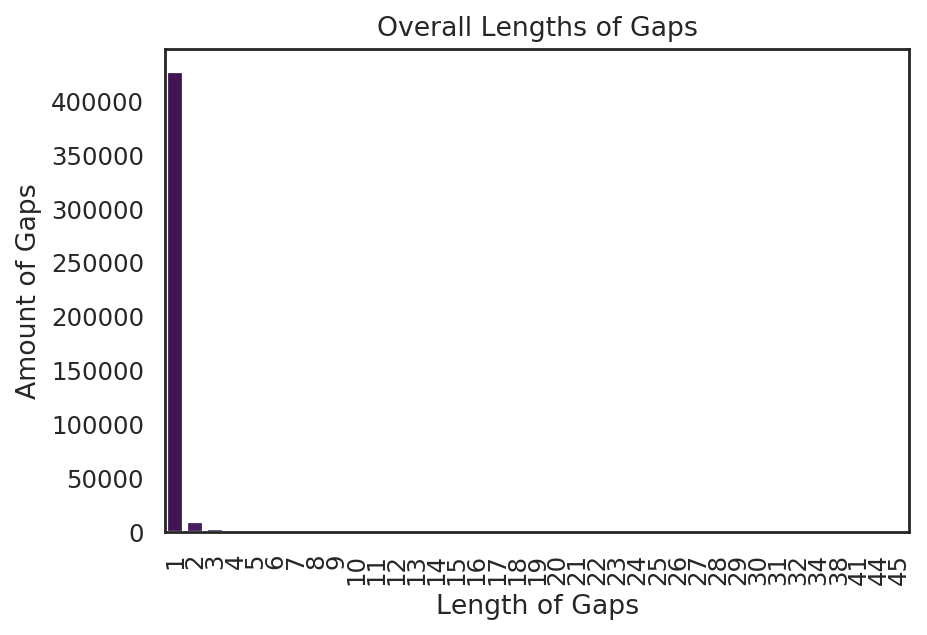

In [38]:
missing_data_counts = gap_lengths_df['gap_length'].value_counts(normalize=False, sort=False)

x = missing_data_counts.index#[0:20]
y = missing_data_counts.values#[0:20]

pal = sns.color_palette("viridis", len(y))
rank = y.argsort().argsort()
sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])#, hue=x, dodge=False)
plt.ylabel('Amount of Gaps');
plt.xlabel('Length of Gaps');
plt.title('Overall Lengths of Gaps');
plt.xticks(rotation=90)
plt.show()

In [39]:
np.log(3)

1.0986122886681098

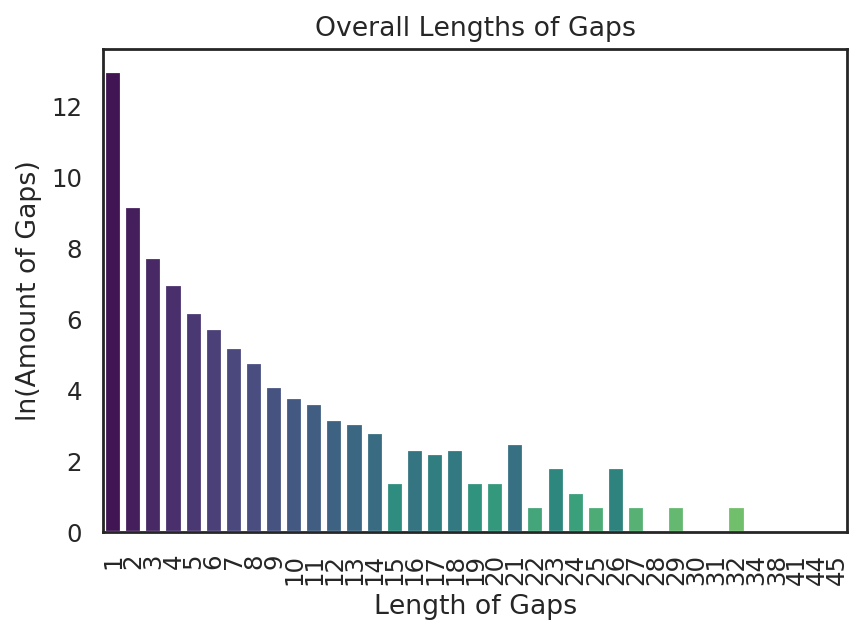

In [40]:
missing_data_counts = gap_lengths_df['gap_length'].value_counts(normalize=False, sort=False)

x = missing_data_counts.index#[2:]
y = np.log(missing_data_counts.values)#[2:]

pal = sns.color_palette("viridis", len(y))
rank = y.argsort().argsort()
sns.barplot(x=x, y=y, palette=np.array(pal[::-1])[rank])#, hue=x, dodge=False)
plt.ylabel('ln(Amount of Gaps)');
plt.xlabel('Length of Gaps');
plt.title('Overall Lengths of Gaps');
plt.xticks(rotation=90)
plt.show()